In [1]:
import full_model
import fast_model
import fast_model_improved
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import pickle

## Load the model

In [7]:
# Load the graph from the file
save_path = '/Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/facebook.gpickle'
try:
    with open(save_path, 'rb') as f:
        G_fb = pickle.load(f)
    print(f"Graph loaded from {save_path}")
except Exception as e:
    print(f"An error occurred while loading the graph: {e}")

# Display basic information about the graph
print(f"Number of nodes: {G_fb.number_of_nodes()}")
print(f"Number of edges: {G_fb.number_of_edges()}")
print(f"Average degree: {sum(dict(G_fb.degree()).values()) / G_fb.number_of_nodes():.2f}")

# Perform additional operations on the graph
# Example: Print the neighbors of node 0
if 0 in G_fb:
    print(f"Neighbors of node 0: {list(G_fb.neighbors(0))}")
else:
    print("Node 0 is not in the graph")

Graph loaded from /Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/facebook.gpickle
Number of nodes: 4039
Number of edges: 88234
Average degree: 43.69
Neighbors of node 0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

In [8]:
def generate_and_find_inf(steps, num_influencers=0):

    model_inf = fast_model_improved.InfluenceDeinfluenceModel(G_fb)
    model_inf.set_initial_states()
    initial_influencers = model_inf.greedy_hill_climbing(num_influencers, steps)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Optimized Initial Influencers:", initial_influencers)

    return model_inf, initial_influencers

In [9]:
inf_steps = 2
num_influencers = 5

results = generate_and_find_inf(inf_steps, num_influencers=num_influencers)

(model, optimized_influencers) = results

print("Optimized Influencers:", optimized_influencers)

Optimized Initial Influencers: {0, 107, 3437, 1684, 1912}
Optimized Influencers: {0, 107, 3437, 1684, 1912}


In [11]:
deinf_steps = 3
deinf_num = 3

de_results = generate_and_find_inf(deinf_steps, deinf_num)
(model, optimized_deinfluencers) = de_results

Optimized Initial Influencers: {0, 107, 3437}


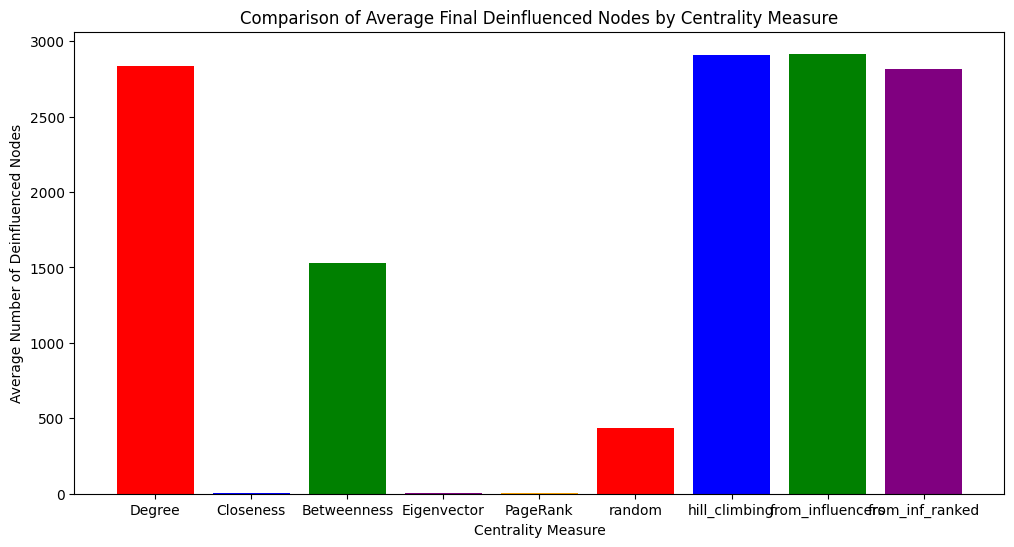

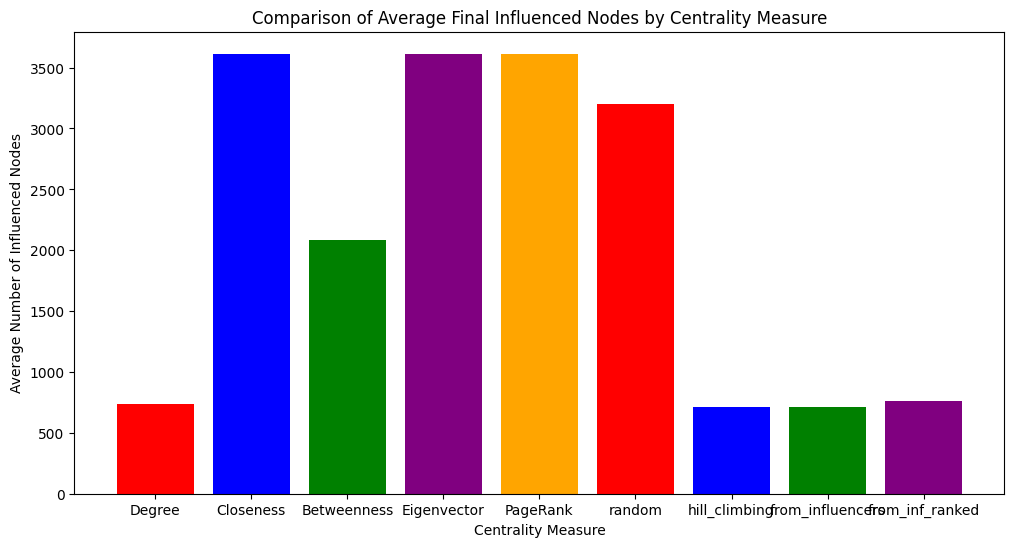

In [13]:
model = full_model.InfluenceDeinfluenceModel(G_fb)

optimized_influencers = {0, 107, 3437, 1684, 1912}
optimized_deinfluencers = {0, 107, 3437}

model.set_initial_states()
model.set_influencers(optimized_influencers)
model.selected_influencers = optimized_influencers
model.set_deinfluencers(optimized_deinfluencers)

# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        deinfluenced_count = model.count_deinfluenced()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_deinfluenced += deinfluenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        influenced_count = model.evaluate_influence()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_influenced += influenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced

# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 3

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
optimized_deinfluencers = {0, 107, 3437}
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 10  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()

plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()
